Imports and project setup

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.config import get_paths, set_seed
from src.preprocessing import minmax_scale_1d
from src.stats import kruskal_wallis_epsilon2, dunn_posthoc_holm
from src.io import save_table, save_figure

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load processed datasets (CSV-first)

In [2]:
paths = get_paths()
_ = set_seed(42)

X_pct = pd.read_csv(paths.processed / "X_pct_contractile.csv")  # column: pct_contractile_area
y_group = pd.read_csv(paths.processed / "y_group.csv")["group"]
y_days = pd.read_csv(paths.processed / "y_days.csv")["days_post_btx"]

assert len(X_pct) == len(y_group) == len(y_days), "Mismatched lengths among processed datasets."
assert "pct_contractile_area" in X_pct.columns, "Expected column 'pct_contractile_area' not found."

print("Loaded:")
print("- X_pct:", X_pct.shape)
print("- y_group:", y_group.shape)
print("- y_days:", y_days.shape)

X_pct.head(3)


Loaded:
- X_pct: (571, 1)
- y_group: (571,)
- y_days: (571,)


,pct_contractile_area
0,0.484456
1,0.407464
2,0.364170


Build EHAT dataset

In [3]:
pct = X_pct["pct_contractile_area"].astype(float).to_numpy()
pct_norm = minmax_scale_1d(pct)

ehat_norm = 1.0 - pct_norm  # higher = more atrophy

df_ehat = pd.DataFrame({
    "pct_contractile_area": pct,
    "pct_contractile_area_norm": pct_norm,
    "ehat_norm": ehat_norm,
    "group": y_group.values,
    "days_post_btx": y_days.values,
})

df_ehat.head()


,pct_contractile_area,pct_contractile_area_norm,ehat_norm,group,days_post_btx
0,0.484456,0.608090,0.391910,GC,0
1,0.407464,0.494977,0.505023,GC,0
2,0.364170,0.431371,0.568629,GC,0
3,0.612266,0.795864,0.204136,GC,0
4,0.676517,0.890261,0.109739,GC,0


Save EHAT dataset (processed)

In [4]:
out_csv = paths.processed / "ehat_dataset.csv"
df_ehat.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")

Saved: c:\Users\modre\Documents\masseter\data\processed\ehat_dataset.csv


Summary by group (mean ± SD)

In [5]:
order = ["GC", "G2", "G5", "G7", "G14"]

summary = (
    df_ehat.groupby(["group", "days_post_btx"])
    .agg(
        n=("group", "size"),
        ehat_mean=("ehat_norm", "mean"),
        ehat_sd=("ehat_norm", "std"),
        pct_mean=("pct_contractile_area", "mean"),
        pct_sd=("pct_contractile_area", "std"),
    )
    .reset_index()
    .sort_values("days_post_btx")
)

summary

,group,days_post_btx,n,ehat_mean,ehat_sd,pct_mean,pct_sd
4,GC,0,120,0.345884,0.141317,0.515784,0.096189
1,G2,2,110,0.421234,0.164430,0.464496,0.111920
2,G5,5,121,0.422975,0.163122,0.463311,0.111031
3,G7,7,110,0.414101,0.148866,0.469351,0.101327
0,G14,14,110,0.465905,0.172134,0.434090,0.117164


In [6]:
save_table(summary, paths.results / "tables" / "ehat_summary_by_group.csv")

WindowsPath('c:/Users/modre/Documents/masseter/results/tables/ehat_summary_by_group.csv')

Boxplot (pct_contractile_area by group)

C:\Users\modre\AppData\Local\Temp\ipykernel_36820\1216862638.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=order, showfliers=True)


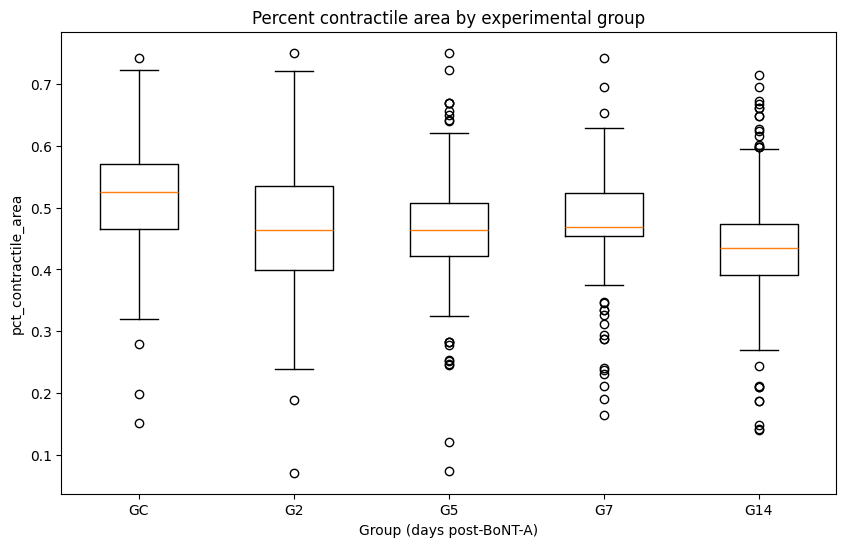

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

data = [df_ehat.loc[df_ehat["group"] == g, "pct_contractile_area"].dropna().values for g in order]
ax.boxplot(data, labels=order, showfliers=True)

ax.set_title("Percent contractile area by experimental group")
ax.set_xlabel("Group (days post-BoNT-A)")
ax.set_ylabel("pct_contractile_area")

save_figure(fig, paths.results/ "figures" / "pct_contractile_area_boxplot.png", dpi=300)
plt.show()


Kruskal–Wallis + epsilon² + Dunn–Holm (pct_contractile_area)

In [8]:
kw_pct = kruskal_wallis_epsilon2(
    df_ehat, value_col="pct_contractile_area", group_col="group", order=order
)
kw_pct

,test,value_col,group_col,H,p_value,epsilon2,k_groups,n_total,group_order
0,Kruskal–Wallis,pct_contractile_area,group,50.417757,2.953735e-10,0.08201,5,571,"[GC, G2, G5, G7, G14]"


In [9]:
save_table(kw_pct, paths.results / "tables" / "pct_contractile_area_kw_summary.csv")

WindowsPath('c:/Users/modre/Documents/masseter/results/tables/pct_contractile_area_kw_summary.csv')

In [10]:
dunn_pct = dunn_posthoc_holm(
    df_ehat, value_col="pct_contractile_area", group_col="group", order=order
)
dunn_pct

,GC,G2,G5,G7,G14
GC,1.000000e+00,0.000776,0.000041,0.015251,5.138563e-11
G2,7.760898e-04,1.000000,0.778362,0.778362,1.638398e-02
G5,4.118798e-05,0.778362,1.000000,0.434631,5.986391e-02
G7,1.525062e-02,0.778362,0.434631,1.000000,1.006325e-03
G14,5.138563e-11,0.016384,0.059864,0.001006,1.000000e+00


In [11]:
save_table(dunn_pct, paths.results / "tables" / "pct_contractile_area_dunn_holm_pvalues.csv")

WindowsPath('c:/Users/modre/Documents/masseter/results/tables/pct_contractile_area_dunn_holm_pvalues.csv')

Boxplot (EHAT_norm by group)

C:\Users\modre\AppData\Local\Temp\ipykernel_36820\3303013795.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=order, showfliers=True)


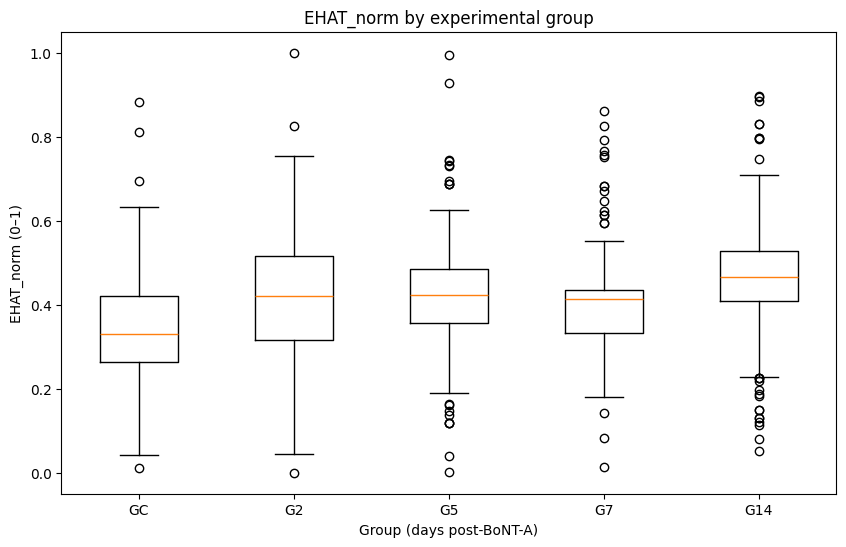

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

data = [df_ehat.loc[df_ehat["group"] == g, "ehat_norm"].dropna().values for g in order]
ax.boxplot(data, labels=order, showfliers=True)

ax.set_title("EHAT_norm by experimental group")
ax.set_xlabel("Group (days post-BoNT-A)")
ax.set_ylabel("EHAT_norm (0–1)")

save_figure(fig, paths.results / "figures" / "ehat_norm_boxplot.png", dpi=300)
plt.show()

Kruskal–Wallis + epsilon² + Dunn–Holm (EHAT_norm)

In [13]:
kw_ehat = kruskal_wallis_epsilon2(
    df_ehat, value_col="ehat_norm", group_col="group", order=order
)
kw_ehat

,test,value_col,group_col,H,p_value,epsilon2,k_groups,n_total,group_order
0,Kruskal–Wallis,ehat_norm,group,50.417757,2.953735e-10,0.08201,5,571,"[GC, G2, G5, G7, G14]"


In [14]:
save_table(kw_ehat, paths.results / "tables" / "ehat_norm_kw_summary.csv")

WindowsPath('c:/Users/modre/Documents/masseter/results/tables/ehat_norm_kw_summary.csv')

In [15]:
dunn_ehat = dunn_posthoc_holm(
    df_ehat, value_col="ehat_norm", group_col="group", order=order
)
dunn_ehat

,GC,G2,G5,G7,G14
GC,1.000000e+00,0.000776,0.000041,0.015251,5.138563e-11
G2,7.760898e-04,1.000000,0.778362,0.778362,1.638398e-02
G5,4.118798e-05,0.778362,1.000000,0.434631,5.986391e-02
G7,1.525062e-02,0.778362,0.434631,1.000000,1.006325e-03
G14,5.138563e-11,0.016384,0.059864,0.001006,1.000000e+00


In [16]:
save_table(dunn_ehat, paths.results / "tables" / "ehat_norm_dunn_holm_pvalues.csv")

WindowsPath('c:/Users/modre/Documents/masseter/results/tables/ehat_norm_dunn_holm_pvalues.csv')

Final checks and artifact list

In [17]:
print("EHAT modeling completed.")
print("Key outputs:")
print("-", paths.processed / "ehat_dataset.csv")
print("-", paths.results / "tables" / "ehat_summary_by_group.csv")
print("-", paths.results / "tables" / "pct_contractile_area_kw_summary.csv")
print("-", paths.results / "tables" / "ehat_norm_kw_summary.csv")
print("-", paths.results / "figures" / "pct_contractile_area_boxplot.png")
print("-", paths.results / "figures" / "ehat_norm_boxplot.png")

EHAT modeling completed.
Key outputs:
- c:\Users\modre\Documents\masseter\data\processed\ehat_dataset.csv
- c:\Users\modre\Documents\masseter\results\tables\ehat_summary_by_group.csv
- c:\Users\modre\Documents\masseter\results\tables\pct_contractile_area_kw_summary.csv
- c:\Users\modre\Documents\masseter\results\tables\ehat_norm_kw_summary.csv
- c:\Users\modre\Documents\masseter\results\figures\pct_contractile_area_boxplot.png
- c:\Users\modre\Documents\masseter\results\figures\ehat_norm_boxplot.png
